In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import gaussian_process.regression as gpr
from gaussian_process.kernels import RBF

### 1D case

In [2]:
key = random.PRNGKey(0)

def func(x,noise=0.0):
    return jnp.sin(x) + noise*random.normal(key,x.shape)

def grad_func(x,noise=0.0):
    return jnp.cos(x) + noise*random.normal(key,x.shape)

In [3]:
bounds = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 2
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = (9,)
derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_values = grad_func(derivative_grid,noise)
data_split = (num_datapoints, ) + num_derivpoints

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 5
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()
kernel_params = (1.0, 1.0)

In [4]:
model = gpr.ExactGPR(kernel,data_split,kernel_params,noise_var=noise**2)
model.fit(X_data,Y_data)
(means_full, stds_full) = model.predict(grid.reshape(-1,1),True)
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

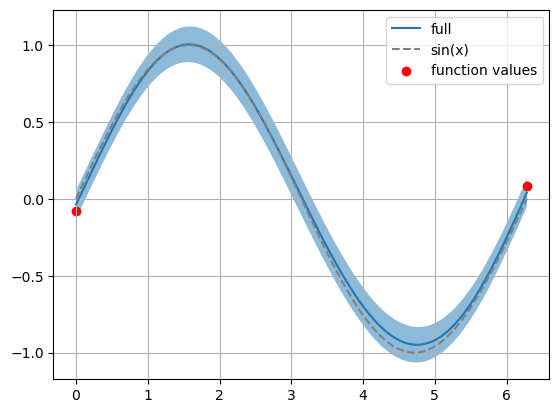

In [5]:
plt.plot(grid,means_full,label="full")
plt.fill_between(grid,means_full-stds_full,means_full+stds_full,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()

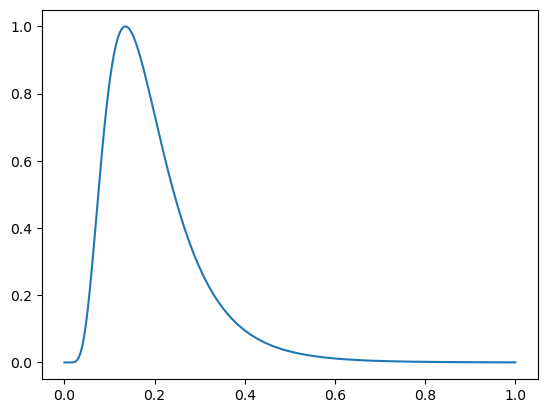

In [6]:
def lognorm(x):
    return jnp.exp(-0.5*((jnp.log(x)+2.0)/0.5)**2)

grid = jnp.linspace(0,1,500)
y = lognorm(grid)
plt.plot(grid,y)

In [7]:
grid[jnp.argmax(y)]

DeviceArray(0.13627255, dtype=float32)

0.09819639


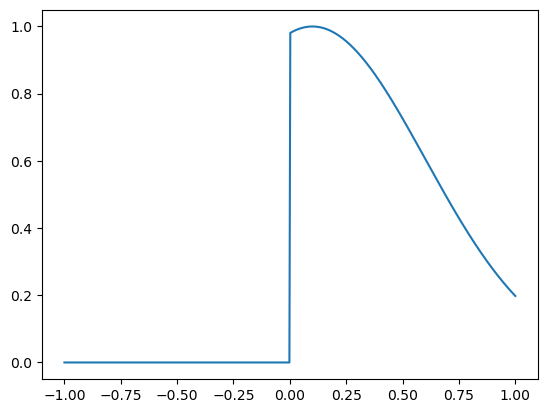

In [8]:
def truncnormal(x):
    if x<0:
        return 0.0
    return jnp.exp(-0.5*((x-0.1)/0.5)**2)

grid = jnp.linspace(-1,1,500)
y = jnp.array([truncnormal(x) for x in grid])
plt.plot(grid,y)
print(grid[jnp.argmax(y)])

In [47]:
from jax.scipy.linalg import solve
from functools import partial
from jax import jit

In [44]:
def Positive():
    f = lambda x: jnp.where(x > 0, 0.0, -jnp.inf)
    return f

def Greater(val):
    f = lambda x: jnp.where(x > val, 0.0, -jnp.inf)
    return f

class MaximumAPosteriori:
    def __init__(self, kernel_constraint=Positive(), noise_constraint=Greater(1e-4), noise_prior=None) -> None:
        '''
            If a noise prior is given it must be in log form and return -jnp.inf for noise values < 0
        '''
        self.kernel_constraint = kernel_constraint
        self.noise_constraint = noise_constraint
        self.noise_prior = noise_prior

    def __call__(self, fitmatrix, fitvector, params):
        '''
            Wrapper around the pure function self.forward

            If a noise prior distribution is given it is used instead of the noise_constraint
        '''
        if self.noise_prior is None:
            return self.forward(fitmatrix, fitvector, params, self.kernel_constraint, self.noise_constraint)
        
        return self.forward(fitmatrix, fitvector, params, self.kernel_constraint, self.noise_prior)
    
    @partial(jit, static_argnums=(0,))
    def forward(self, fitmatrix, fitvector, params, kernel_constraint, noise_constraint):
        '''
            Does not calculate the full log Maximum a Posteriori 
            but just the parts that matter for the derivative.
        '''
        _, logdet = jnp.linalg.slogdet(fitmatrix)
        fitvector = fitvector.reshape(-1)
        mle = -0.5*(logdet + fitvector.T@solve(fitmatrix,fitvector))
        prob_noise = noise_constraint(params[0])
        prob_kernel = jnp.sum(kernel_constraint(params[1:]))

        return mle + prob_noise + prob_kernel



In [46]:
x = jnp.array([-1.,2,0.5,-3.7])
a = Greater(5.0)
a(x)

DeviceArray([-inf, -inf, -inf, -inf], dtype=float32, weak_type=True)